# Imports

In [1]:
# install additional packages if running on Emscripten
import platform

notebook_platform = platform.uname()
if notebook_platform.system == "Emscripten":
    import piplite

    await piplite.install(["openpyxl", "seaborn"])

In [2]:
from enum import Enum
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lmfit.models import LinearModel
import numpy as np

sns.set_style("ticks", {"axes.grid": True})

# Data

In [3]:
this_file = pathlib.Path().absolute()
data_dir = this_file.parent / "data"
data_dir

WindowsPath('c:/Users/Legion/workspace/tld_let_calibration/data')

In [4]:
radiation = Enum("rad_type", "proton Co60")
detector = Enum("detector", "mcp mts")

## Monte-Carlo results

In [5]:
df_mc = pd.read_csv(data_dir / "interim" / "mc.csv")
df_mc

,z_mm,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,0.0425,11.227477,11.633363,35.385786,11.088739,11.119699,11.184843
1,0.1275,11.232338,11.724956,35.667142,11.088840,11.128653,11.201058
2,0.2125,11.234249,11.787788,36.679750,11.088901,11.135544,11.213373
3,0.2975,11.270811,11.869649,36.399744,11.128965,11.181241,11.259141
4,0.3825,11.277012,11.922945,37.028460,11.132754,11.190703,11.270034
...,...,...,...,...,...,...,...
395,33.6175,0.000000,95.157937,667.910476,0.000000,50.939122,64.914758
396,33.7025,0.000000,93.838051,666.153374,0.000000,49.928610,63.836474
397,33.7875,0.000000,93.075406,809.382192,0.000000,50.108000,68.220748
398,33.8725,0.000000,93.619083,611.994822,0.000000,50.774796,65.096386


In [6]:
# Reshaping the DataFrame using melt
df_melted = pd.melt(df_mc, id_vars="z_mm", var_name="LET_Type", value_name="LET")
df_melted["averaging"] = df_melted["LET_Type"].apply(lambda x: x[0])
df_melted["particles"] = df_melted["LET_Type"].apply(lambda x: x[4:])
df_melted = df_melted.drop(columns="LET_Type")
df_melted.LET /= 10
df_melted

,z_mm,LET,averaging,particles
0,0.0425,1.122748,d,Primaries
1,0.1275,1.123234,d,Primaries
2,0.2125,1.123425,d,Primaries
3,0.2975,1.127081,d,Primaries
4,0.3825,1.127701,d,Primaries
...,...,...,...,...
2395,33.6175,6.491476,t,All
2396,33.7025,6.383647,t,All
2397,33.7875,6.822075,t,All
2398,33.8725,6.509639,t,All


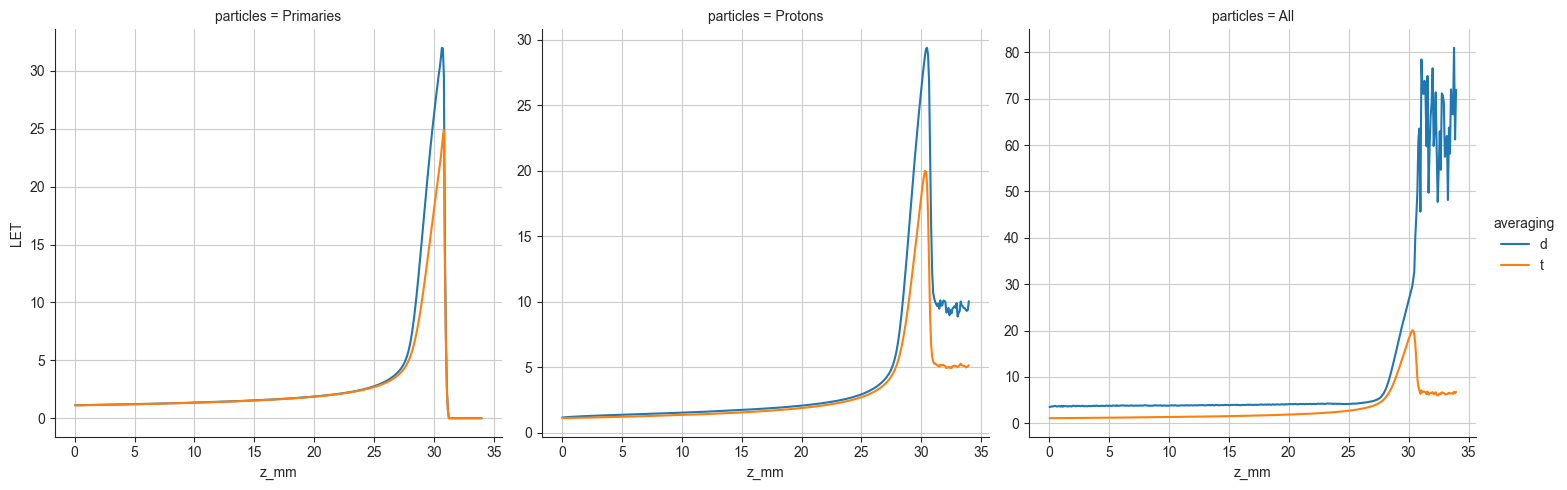

In [7]:
sns.relplot(
    data=df_melted, x="z_mm", y="LET", hue="averaging", col="particles", kind="line", facet_kws=dict(sharey=False)
)

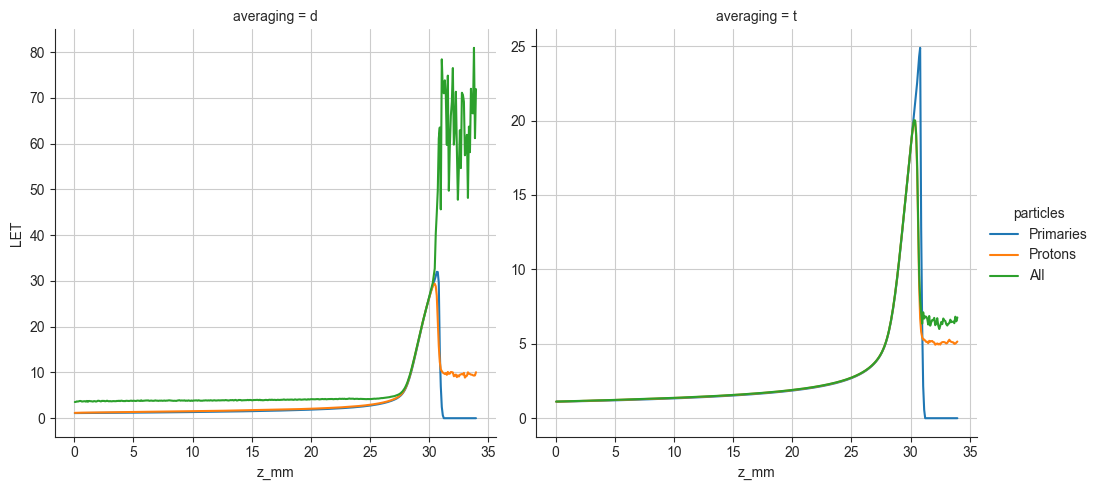

In [8]:
sns.relplot(
    data=df_melted, x="z_mm", y="LET", hue="particles", col="averaging", kind="line", facet_kws=dict(sharey=False)
)

## Detector data

In [9]:
df_eff = pd.read_csv(data_dir / "interim" / "proton_eff.csv")
plexi_to_water = 1.16
shift = 1.2642
step_pmma = 0.00329
extra = 0.65
df_eff["z_mm"] = plexi_to_water * (shift + step_pmma * df_eff.pmma_wheel_steps) + extra
df_eff

,detector,energy_MeV,pmma_wheel_steps,det_id,eff,z_mm
0,mts,4.92,6895,61,0.985627,28.430550
1,mts,4.92,6895,62,0.984895,28.430550
2,mts,4.92,6895,63,0.980375,28.430550
3,mts,4.92,6895,64,0.993604,28.430550
4,mts,4.92,6895,65,0.976298,28.430550
...,...,...,...,...,...,...
126,mcp,55.00,0,2,0.838465,2.116472
127,mcp,55.00,0,3,0.843554,2.116472
128,mcp,55.00,0,4,0.842029,2.116472
129,mcp,55.00,0,5,0.845122,2.116472


In [10]:
sorted(df_eff.pmma_wheel_steps.unique())

[0, 2645, 4462, 5645, 6098, 6365, 6542, 6717, 6802, 6855, 6895]

Text(0, 0.5, 'Efficiency')

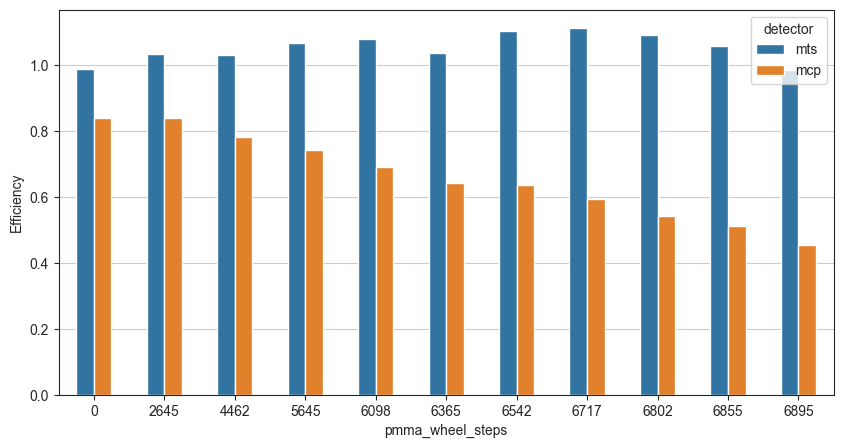

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(df_eff, x="pmma_wheel_steps", y="eff", hue="detector", errorbar=None, width=0.5, ax=ax)
ax.set_ylabel("Efficiency")

<Axes: xlabel='z_mm', ylabel='eff'>

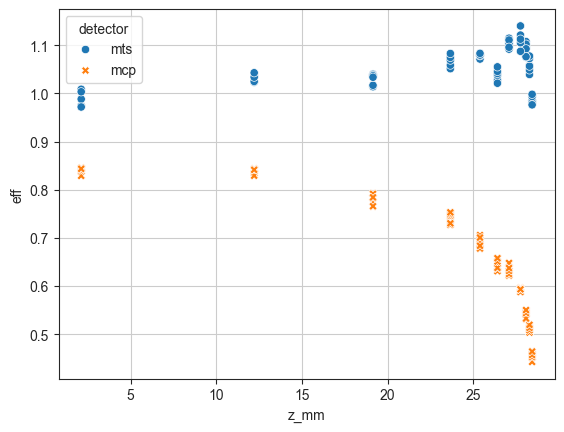

In [12]:
sns.scatterplot(data=df_eff, x="z_mm", y="eff", hue="detector", style="detector")

In [14]:
df_ratio = df_eff[df_eff.detector == detector.mcp.name].copy()
df_ratio.drop(columns=["energy_MeV", "pmma_wheel_steps", "detector"], inplace=True)
# rename eff to mcp_eff
df_ratio.rename(columns={"eff": "mcp_eff"}, inplace=True)
df_ratio = df_ratio.merge(
    df_eff[df_eff.detector == detector.mts.name][["z_mm", "eff"]], on="z_mm", suffixes=("_mcp", "_mts")
)
df_ratio.rename(columns={"eff": "mts_eff"}, inplace=True)
# df_ratio["ratio"] = df_ratio.mts_eff / df_ratio.mcp_eff
df_ratio

,det_id,mcp_eff,z_mm,mts_eff
0,61,0.458801,28.430550,0.985627
1,61,0.458801,28.430550,0.984895
2,61,0.458801,28.430550,0.980375
3,61,0.458801,28.430550,0.993604
4,61,0.458801,28.430550,0.976298
...,...,...,...,...
385,6,0.843410,2.116472,0.974666
386,6,0.843410,2.116472,0.988239
387,6,0.843410,2.116472,0.971826
388,6,0.843410,2.116472,1.008711


In [25]:
df_ratio["ratio"] = float("nan")
df_ratio["ratio_err"] = float("nan")
for name, df_group in df_ratio.groupby("z_mm"):
    x_mean = df_group.mts_eff.mean()
    x_std = df_group.mts_eff.std()
    y_mean = df_group.mcp_eff.mean()
    y_std = df_group.mcp_eff.std()
    df_ratio.loc[df_ratio.z_mm == name, "ratio"] = x_mean / y_mean
    df_ratio.loc[df_ratio.z_mm == name, "ratio_err"] = (x_mean / y_mean) * np.sqrt(
        (x_std / y_mean) ** 2 + (y_std * x_mean / y_mean**2) ** 2
    )
df_ratio

,det_id,mcp_eff,z_mm,mts_eff,ratio,ratio_err
0,61,0.458801,28.430550,0.985627,2.171500,0.079704
1,61,0.458801,28.430550,0.984895,2.171500,0.079704
2,61,0.458801,28.430550,0.980375,2.171500,0.079704
3,61,0.458801,28.430550,0.993604,2.171500,0.079704
4,61,0.458801,28.430550,0.976298,2.171500,0.079704
...,...,...,...,...,...,...
385,6,0.843410,2.116472,0.974666,1.177483,0.023026
386,6,0.843410,2.116472,0.988239,1.177483,0.023026
387,6,0.843410,2.116472,0.971826,1.177483,0.023026
388,6,0.843410,2.116472,1.008711,1.177483,0.023026


<ErrorbarContainer object of 3 artists>

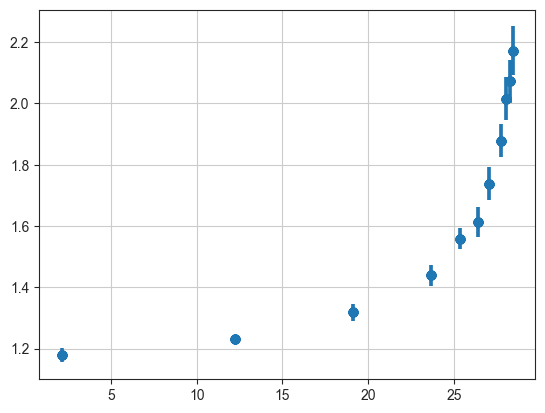

In [29]:
plt.errorbar(df_ratio.z_mm, df_ratio.ratio, yerr=df_ratio.ratio_err, fmt="o")

<Axes: xlabel='z_mm', ylabel='ratio'>

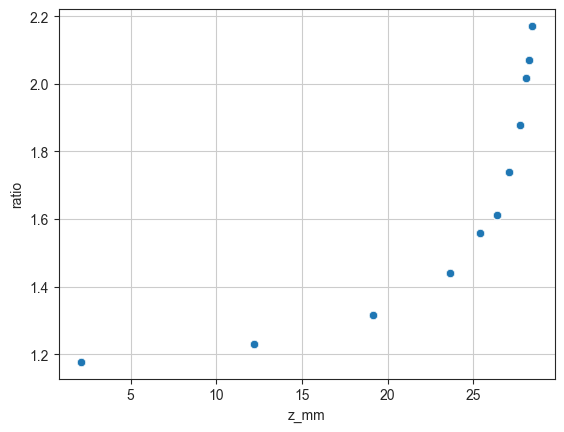

In [26]:
sns.scatterplot(data=df_ratio, x="z_mm", y="ratio")

In [30]:
from scipy.interpolate import griddata


# Define function for interpolation
def interpolate_let(df, averaging, particles, z_mm):
    subset = df[(df["averaging"] == averaging) & (df["particles"] == particles)]

    if len(subset) == 0:
        raise ValueError("No matching rows found for the given averaging and particles.")

    points = subset[["z_mm"]].values
    values = subset["LET"].values

    interpolated_value = griddata(points, values, z_mm, method="linear")

    return interpolated_value  # Assuming you want a single value as the result


# Example usage
averaging_value = "d"
particles_value = "Primaries"
z_mm_value = 2  # Replace this with the desired z_mm value

interpolated_let = interpolate_let(df_melted, averaging_value, particles_value, z_mm_value)
print(f"Interpolated LET value: {interpolated_let}")

Interpolated LET value: 1.1549634573076464


In [31]:
interpolate_let(df_melted, averaging_value, particles_value, df_eff.z_mm.values)

array([9.6151142 , 9.6151142 , 9.6151142 , 9.6151142 , 9.6151142 ,
       9.6151142 , 8.3105744 , 8.3105744 , 8.3105744 , 8.3105744 ,
       8.3105744 , 8.3105744 , 6.90120672, 6.90120672, 6.90120672,
       6.90120672, 6.90120672, 6.90120672, 5.41390815, 5.41390815,
       5.41390815, 5.41390815, 5.41390815, 5.41390815, 4.09384368,
       4.09384368, 4.09384368, 4.09384368, 4.09384368, 4.09384368,
       3.4725942 , 3.4725942 , 3.4725942 , 3.4725942 , 3.4725942 ,
       3.4725942 , 2.91242357, 2.91242357, 2.91242357, 2.91242357,
       2.91242357, 2.91242357, 2.38894634, 2.38894634, 2.38894634,
       2.38894634, 2.38894634, 2.38894634, 1.79780486, 1.79780486,
       1.79780486, 1.79780486, 1.79780486, 1.79780486, 1.42154126,
       1.42154126, 1.42154126, 1.42154126, 1.42154126, 1.42154126,
       1.15872036, 1.15872036, 1.15872036, 1.15872036, 1.15872036,
       9.6151142 , 9.6151142 , 9.6151142 , 9.6151142 , 9.6151142 ,
       9.6151142 , 8.3105744 , 8.3105744 , 8.3105744 , 8.31057

In [32]:
for av in df_melted.averaging.unique():
    for part in df_melted.particles.unique():
        df_eff[f"{av}LET{part}"] = interpolate_let(df_melted, av, part, df_eff.z_mm.values)
df_eff

,detector,energy_MeV,pmma_wheel_steps,det_id,eff,z_mm,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,mts,4.92,6895,61,0.985627,28.430550,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
1,mts,4.92,6895,62,0.984895,28.430550,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
2,mts,4.92,6895,63,0.980375,28.430550,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
3,mts,4.92,6895,64,0.993604,28.430550,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
4,mts,4.92,6895,65,0.976298,28.430550,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
...,...,...,...,...,...,...,...,...,...,...,...,...
126,mcp,55.00,0,2,0.838465,2.116472,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616
127,mcp,55.00,0,3,0.843554,2.116472,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616
128,mcp,55.00,0,4,0.842029,2.116472,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616
129,mcp,55.00,0,5,0.845122,2.116472,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616


<Axes: xlabel='dLETProtons', ylabel='eff'>

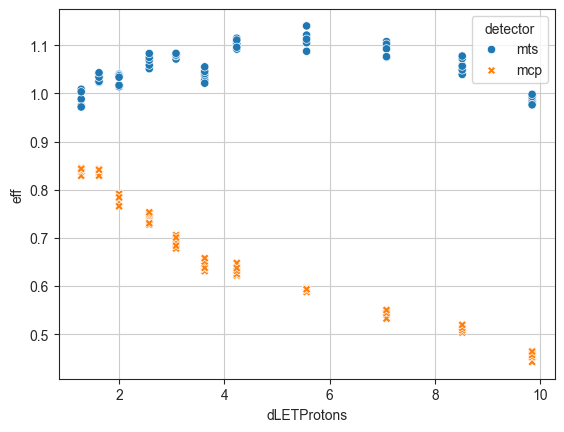

In [33]:
sns.scatterplot(data=df_eff, x="dLETProtons", y="eff", hue="detector", style="detector")

In [34]:
for av in df_melted.averaging.unique():
    for part in df_melted.particles.unique():
        df_ratio[f"{av}LET{part}"] = interpolate_let(df_melted, av, part, df_ratio.z_mm.values)
df_ratio

,det_id,mcp_eff,z_mm,mts_eff,ratio,ratio_err,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,61,0.458801,28.430550,0.985627,2.171500,0.079704,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
1,61,0.458801,28.430550,0.984895,2.171500,0.079704,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
2,61,0.458801,28.430550,0.980375,2.171500,0.079704,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
3,61,0.458801,28.430550,0.993604,2.171500,0.079704,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
4,61,0.458801,28.430550,0.976298,2.171500,0.079704,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
...,...,...,...,...,...,...,...,...,...,...,...,...
385,6,0.843410,2.116472,0.974666,1.177483,0.023026,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616
386,6,0.843410,2.116472,0.988239,1.177483,0.023026,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616
387,6,0.843410,2.116472,0.971826,1.177483,0.023026,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616
388,6,0.843410,2.116472,1.008711,1.177483,0.023026,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616


<Axes: xlabel='dLETProtons', ylabel='ratio'>

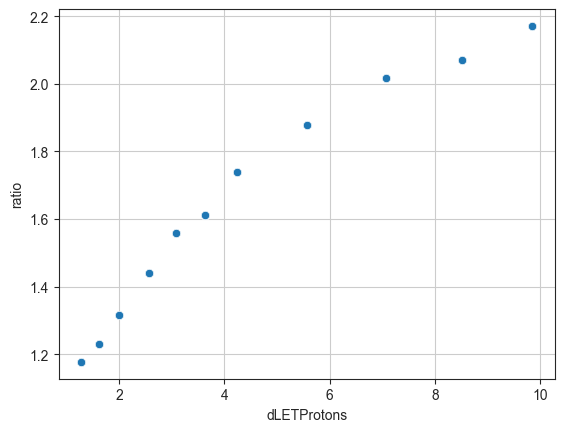

In [35]:
sns.scatterplot(data=df_ratio, x="dLETProtons", y="ratio")

In [36]:
df_ratio

,det_id,mcp_eff,z_mm,mts_eff,ratio,ratio_err,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,61,0.458801,28.430550,0.985627,2.171500,0.079704,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
1,61,0.458801,28.430550,0.984895,2.171500,0.079704,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
2,61,0.458801,28.430550,0.980375,2.171500,0.079704,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
3,61,0.458801,28.430550,0.993604,2.171500,0.079704,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
4,61,0.458801,28.430550,0.976298,2.171500,0.079704,9.615114,9.842002,10.025785,6.883483,6.945030,6.947578
...,...,...,...,...,...,...,...,...,...,...,...,...
385,6,0.843410,2.116472,0.974666,1.177483,0.023026,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616
386,6,0.843410,2.116472,0.988239,1.177483,0.023026,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616
387,6,0.843410,2.116472,0.971826,1.177483,0.023026,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616
388,6,0.843410,2.116472,1.008711,1.177483,0.023026,1.158720,1.278838,3.770632,1.144383,1.157155,1.165616


In [41]:
# Reshaping the DataFrame using melt
df_ratio_melted = pd.melt(
    df_ratio,
    id_vars=["z_mm", "det_id", "mcp_eff", "mts_eff", "ratio", "ratio_err"],
    var_name="LET_Type",
    value_name="LET",
)
df_ratio_melted["averaging"] = df_ratio_melted["LET_Type"].apply(lambda x: x[0])
df_ratio_melted["particles"] = df_ratio_melted["LET_Type"].apply(lambda x: x[4:])
df_ratio_melted = df_ratio_melted.drop(columns="LET_Type")
df_ratio_melted

,z_mm,det_id,mcp_eff,mts_eff,ratio,ratio_err,LET,averaging,particles
0,28.430550,61,0.458801,0.985627,2.171500,0.079704,9.615114,d,Primaries
1,28.430550,61,0.458801,0.984895,2.171500,0.079704,9.615114,d,Primaries
2,28.430550,61,0.458801,0.980375,2.171500,0.079704,9.615114,d,Primaries
3,28.430550,61,0.458801,0.993604,2.171500,0.079704,9.615114,d,Primaries
4,28.430550,61,0.458801,0.976298,2.171500,0.079704,9.615114,d,Primaries
...,...,...,...,...,...,...,...,...,...
2335,2.116472,6,0.843410,0.974666,1.177483,0.023026,1.165616,t,All
2336,2.116472,6,0.843410,0.988239,1.177483,0.023026,1.165616,t,All
2337,2.116472,6,0.843410,0.971826,1.177483,0.023026,1.165616,t,All
2338,2.116472,6,0.843410,1.008711,1.177483,0.023026,1.165616,t,All


In [42]:
df_ratio_melted.averaging.unique()

array(['d', 't'], dtype=object)

In [43]:
df_ratio_melted.particles.unique()

array(['Primaries', 'Protons', 'All'], dtype=object)

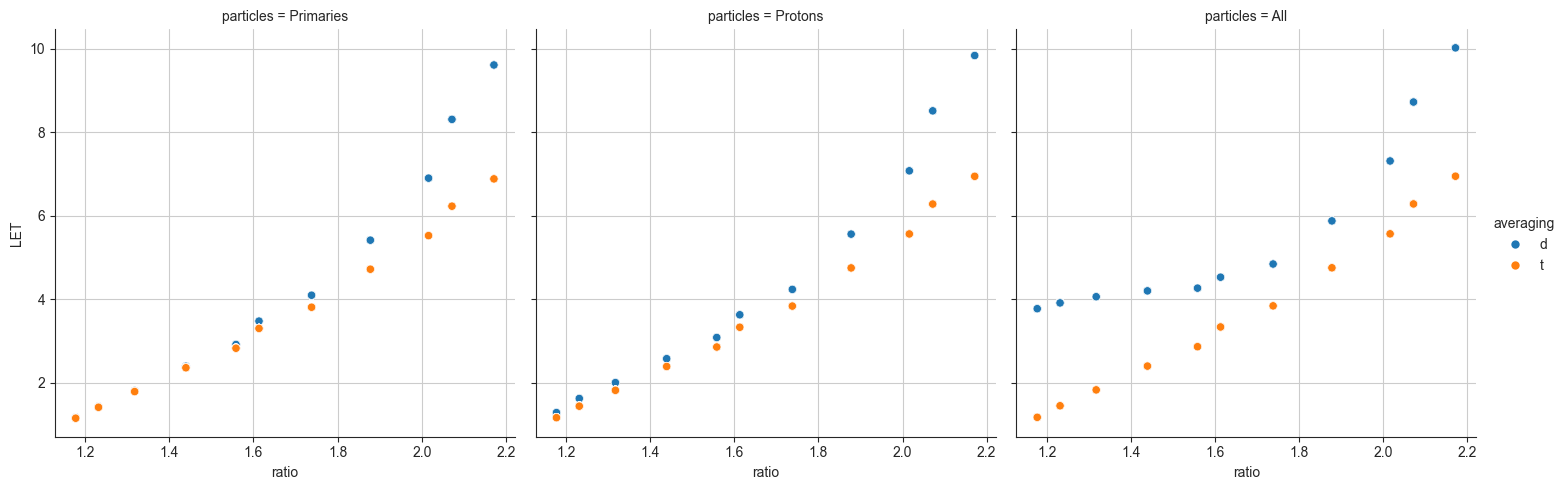

In [44]:
sns.relplot(data=df_ratio_melted, x="ratio", y="LET", hue="averaging", col="particles")

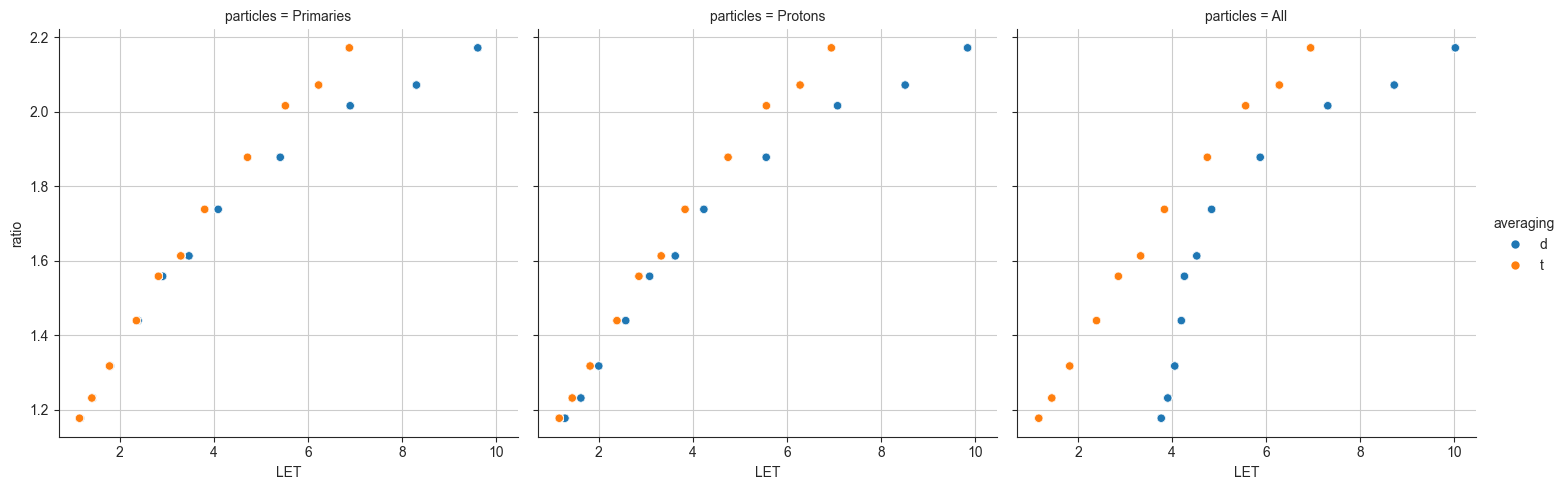

In [45]:
sns.relplot(data=df_ratio_melted, x="LET", y="ratio", hue="averaging", col="particles")

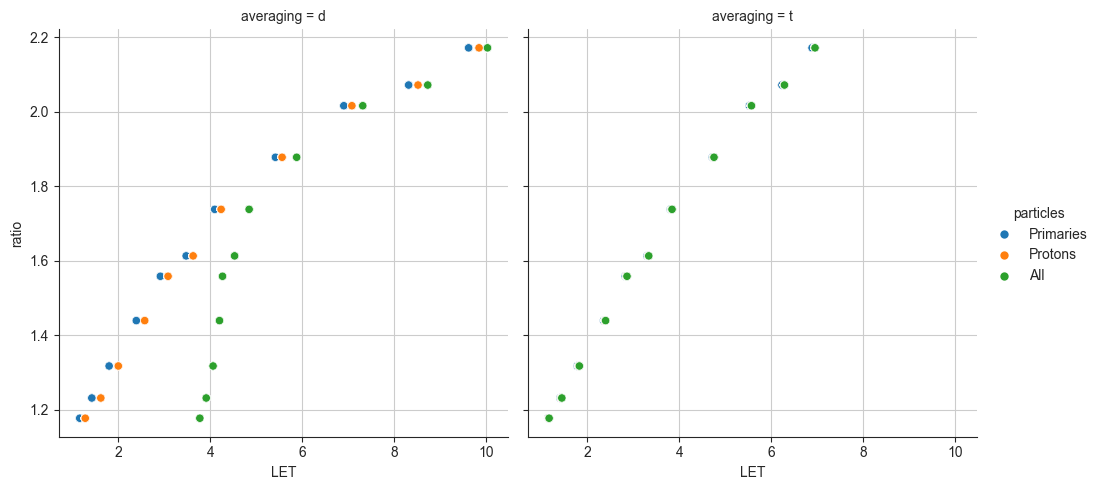

In [46]:
sns.relplot(data=df_ratio_melted, x="LET", y="ratio", hue="particles", col="averaging")

In [47]:
from lmfit.models import LinearModel, QuadraticModel, PolynomialModel


def calibration_function(df, averaging, particles, ratio):
    subset = df[(df["averaging"] == averaging) & (df["particles"] == particles)]
    x = subset.ratio.values.tolist()
    y = subset.LET.values.tolist()
    model = PolynomialModel(degree=3)
    params = model.guess(y, x=x)
    fit = model.fit(y, params, x=x)

    # check if ratio is float
    if isinstance(ratio, float):
        return fit.eval(x=ratio)
    else:
        result = [fit.eval(x=item) for item in ratio]
        return np.array(result)

In [48]:
calibration_function(df_ratio_melted, "d", "Protons", 2.0)

array(7.07511589)

In [49]:
calibration_function(df_ratio_melted, "d", "Protons", [2.0, 2.1])

array([7.07511589, 8.63002359])

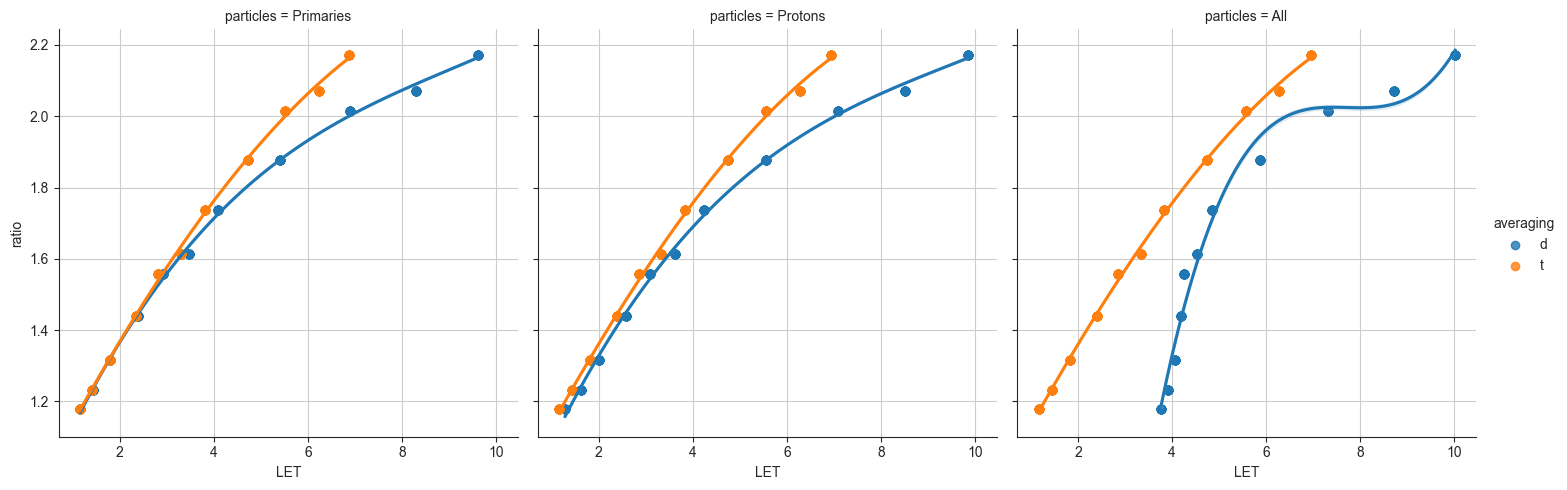

In [50]:
sns.lmplot(data=df_ratio_melted, x="LET", y="ratio", hue="averaging", col="particles", order=3)

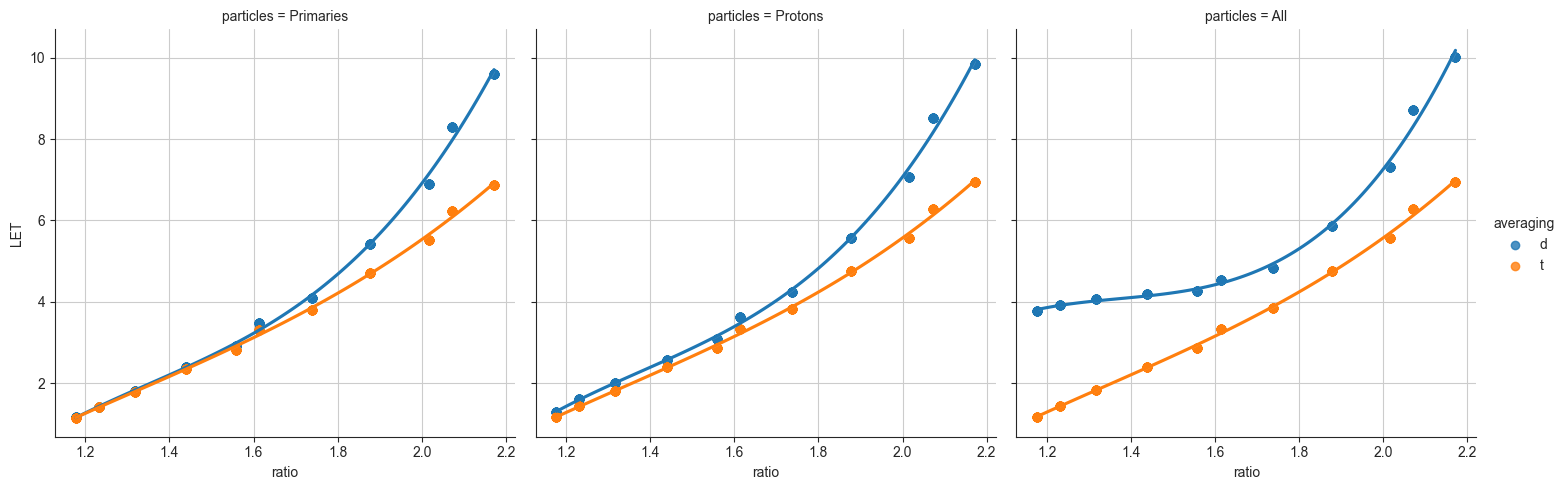

In [51]:
sns.lmplot(data=df_ratio_melted, x="ratio", y="LET", hue="averaging", col="particles", order=3)

In [52]:
df_ratio.to_csv(data_dir / "interim" / "ifj_calib_data.csv", index=False)

# Application

In [53]:
df_dcpt = pd.read_csv(data_dir / "interim" / "ratio_signal.csv")
df_dcpt

,exp,det_id,ratio_signal
0,2a,9,1.103115
1,2a,16,1.026642
2,2a,15,1.057581
3,2a,14,1.091050
4,2a,13,1.086787
5,2a,12,0.958859
6,2a,11,1.013075
7,2a,10,1.162400
8,1a,8,1.334733
9,1a,7,1.269311


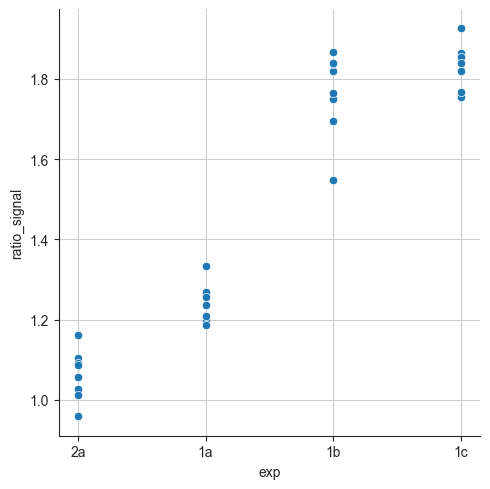

In [54]:
sns.relplot(data=df_dcpt, x="exp", y="ratio_signal")

In [55]:
for av in df_melted.averaging.unique():
    for part in df_melted.particles.unique():
        df_dcpt[f"{av}LET{part}"] = calibration_function(df_ratio_melted, av, part, df_dcpt.ratio_signal.values)
df_dcpt

,exp,det_id,ratio_signal,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,2a,9,1.103115,0.737115,0.857757,3.609726,0.803677,0.811443,0.818798
1,2a,16,1.026642,0.252394,0.323416,3.305916,0.434372,0.427984,0.433102
2,2a,15,1.057581,0.457295,0.550440,3.442608,0.585664,0.585525,0.591651
3,2a,14,1.091050,0.665307,0.779227,3.569122,0.746402,0.752218,0.759275
4,2a,13,1.086787,0.639547,0.750997,3.554163,0.726084,0.731186,0.738133
5,2a,12,0.958859,-0.245248,-0.233276,2.930878,0.092148,0.069370,0.071756
6,2a,11,1.013075,0.158387,0.218783,3.239503,0.367123,0.357759,0.362389
7,2a,10,1.162400,1.068746,1.216903,3.775392,1.080840,1.096790,1.105325
8,1a,8,1.334733,1.902575,2.087289,4.039496,1.864532,1.893253,1.902962
9,1a,7,1.269311,1.600446,1.777861,3.965145,1.568662,1.594199,1.603813


In [79]:
df_mc_dcpt = pd.DataFrame(
    {"exp": ["1a", "1b", "1c", "2a"], "LETf_p": [1.14, 4.39, 5.68, 0.58], "LETd_p": [2.01, 7.55, 10.1, 0.9]}
)
df_mc_dcpt

,exp,LETf_p,LETd_p
0,1a,1.14,2.01
1,1b,4.39,7.55
2,1c,5.68,10.10
3,2a,0.58,0.90


<Axes: xlabel='exp', ylabel='dLETProtons'>

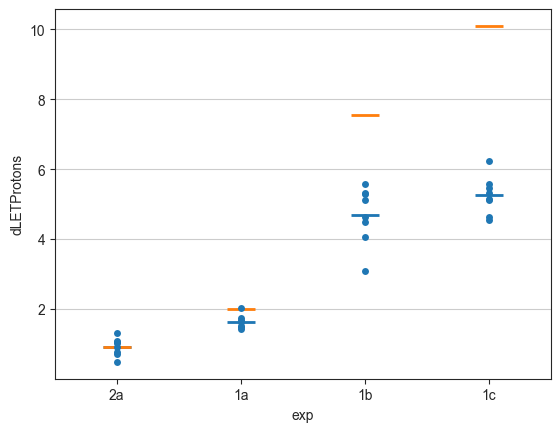

In [80]:
fig, ax = plt.subplots()
sns.pointplot(
    data=df_dcpt, x="exp", y="dLETProtons", linestyles="none", markers="_", markersize=20, errorbar=None, ax=ax
)
sns.stripplot(data=df_dcpt, x="exp", y="dLETProtons", jitter=False, ax=ax)
sns.pointplot(data=df_mc_dcpt, x="exp", y="LETd_p", linestyles="none", markers="_", markersize=20, errorbar=None, ax=ax)

In [81]:
df_mc_dcpt

,exp,LETf_p,LETd_p
0,1a,1.14,2.01
1,1b,4.39,7.55
2,1c,5.68,10.10
3,2a,0.58,0.90


<Axes: xlabel='exp', ylabel='tLETProtons'>

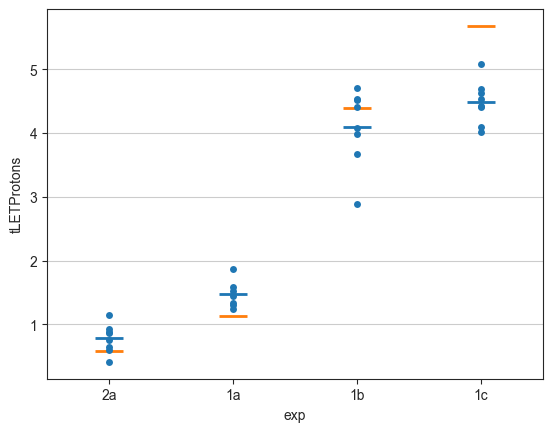

In [82]:
fig, ax = plt.subplots()
sns.pointplot(
    data=df_dcpt, x="exp", y="tLETProtons", linestyles="none", markers="_", markersize=20, errorbar=None, ax=ax
)
sns.stripplot(data=df_dcpt, x="exp", y="tLETProtons", jitter=False, ax=ax)
sns.pointplot(data=df_mc_dcpt, x="exp", y="LETf_p", linestyles="none", markers="_", markersize=20, errorbar=None, ax=ax)

In [83]:
df_ifj_calib_to_dump = pd.DataFrame(
    {
        "ratio": np.arange(start=0.96, stop=2.3, step=0.01),
    }
)
for av in df_melted.averaging.unique():
    for part in df_melted.particles.unique():
        df_ifj_calib_to_dump[f"{av}LET{part}"] = calibration_function(
            df_ratio_melted, av, part, df_ifj_calib_to_dump.ratio.values
        )
df_ifj_calib_to_dump

,ratio,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,0.96,0.446355,0.488093,3.661522,0.430876,0.416949,0.420089
1,0.97,0.482936,0.532594,3.679269,0.462654,0.450871,0.454419
2,0.98,0.519301,0.576599,3.696034,0.494737,0.485029,0.488969
3,0.99,0.555474,0.620133,3.711855,0.527127,0.519425,0.523742
4,1.00,0.591474,0.663224,3.726771,0.559823,0.554061,0.558740
...,...,...,...,...,...,...,...
129,2.25,10.809837,11.096957,11.426417,7.408100,7.485284,7.489199
130,2.26,10.993928,11.289195,11.638370,7.487709,7.567237,7.571351
131,2.27,11.180541,11.484244,11.854355,7.567756,7.649702,7.654026
132,2.28,11.369698,11.682131,12.074411,7.648242,7.732679,7.737227


In [84]:
df_ifj_calib_to_dump.to_csv(data_dir / "interim" / "ifj_calib.csv", index=False)

# New data

In [62]:
df_dctp = pd.read_excel(data_dir / "interim" / "ifj_dcpt_data.xlsx", sheet_name="all_dets")
df_dctp

,detector,exp,signal,eff,det_dose
0,mcp,2a,1.018293e+09,0.911573,0.919778
1,mcp,2a,1.123204e+09,1.005490,1.014539
2,mcp,2a,1.083053e+09,0.969547,0.978273
3,mcp,2a,1.037436e+09,0.928711,0.937069
4,mcp,2a,1.068922e+09,0.956896,0.965508
...,...,...,...,...,...
58,mts,1c,4.858786e+07,0.955407,0.744262
59,mts,1c,4.716734e+07,0.927475,0.722503
60,mts,1c,4.813481e+07,0.946499,0.737322
61,mts,1c,4.731664e+07,0.930411,0.724790


In [67]:
df_ratio = df_dctp[df_dctp.detector == "mts"].groupby(["exp"])["eff"].mean().reset_index()
df_ratio["eff"] = df_ratio["eff"] / df_dctp[df_dctp.detector == "mcp"].groupby(["exp"])["eff"].mean().reset_index().eff
# rename eff to ratio

# df_ratio["ratio"] = float('nan')
# df_ratio["ratio_err"] = float('nan')
# for name, df_group in df_ratio.groupby("z_mm"):
#     x_mean = df_group.mts_eff.mean()
#     x_std = df_group.mts_eff.std()
#     y_mean = df_group.mcp_eff.mean()
#     y_std = df_group.mcp_eff.std()
#     df_ratio.loc[df_ratio.z_mm == name, "ratio"] = x_mean / y_mean
#     df_ratio.loc[df_ratio.z_mm == name, "ratio_err"] = (x_mean / y_mean) * np.sqrt((x_std / y_mean) ** 2 + (y_std * x_mean / y_mean ** 2) ** 2)
# df_ratio

df_ratio.rename(columns={"eff": "ratio"}, inplace=True)
df_ratio

,exp,ratio
0,1a,1.247122
1,1b,1.763487
2,1c,1.829854
3,2a,1.060380


In [68]:
df_ratio["tLETProtons"] = calibration_function(df_ratio_melted, "t", "Protons", df_ratio["ratio"].values)
df_ratio["dLETProtons"] = calibration_function(df_ratio_melted, "d", "Protons", df_ratio["ratio"].values)
df_ratio["tLETAll"] = calibration_function(df_ratio_melted, "t", "All", df_ratio["ratio"].values)
df_ratio["dLETAll"] = calibration_function(df_ratio_melted, "d", "All", df_ratio["ratio"].values)
df_ratio

,exp,ratio,tLETProtons,dLETProtons,tLETAll,dLETAll
0,1a,1.247122,1.492202,1.668414,1.501693,3.934454
1,1b,1.763487,4.024199,4.511552,4.028908,5.077949
2,1c,1.829854,4.419788,5.097576,4.423573,5.517400
3,2a,1.060380,0.599607,0.570217,0.605816,3.454007


In [69]:
df_ratio.to_excel(data_dir / "interim" / "ifj_results.xlsx", index=False)